In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -q /content/drive/MyDrive/Colab/2302_NDSB/train.zip
! unzip -q /content/drive/MyDrive/Colab/2302_NDSB/test.zip

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path, PurePath
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import zipfile

In [ ]:
directory_names = sorted(set(Path("train/").glob("*")))
classes = []
for i in range(len(directory_names)):
  classes.append(directory_names[i].name)

In [ ]:
! pip -q install tensorflow-addons
import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.efficientnet_v2 import EfficientNetV2M

In [ ]:
BATCH_SIZE = 256
EPOCHS = 100

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=360,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=255,
    validation_split=0.1 
    )
 
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(75, 75),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') # set as training data
 
validation_generator = train_datagen.flow_from_directory(
    '/content/train', # same directory as training data
    target_size=(75, 75),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 27359 images belonging to 121 classes.
Found 2977 images belonging to 121 classes.


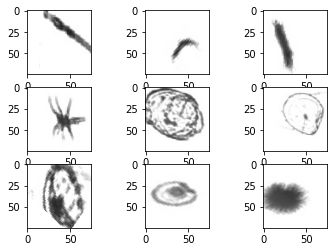

In [ ]:
for x_batch, y_batch in train_generator:
  for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(x_batch[i])#/255)
  plt.show()
  break

In [ ]:
import gc
del directory_names, classes
gc.collect() 

In [ ]:
conv_base = EfficientNetV2M(
    weights='imagenet',
    include_top=False,
    input_shape=(75,75,3),
    include_preprocessing=False,
)

214201816/214201816 [==============================] - 7s 0us/step


In [ ]:
conv_base.trainable = True
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(121,activation='softmax'))
model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics='accuracy')

Checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab/2302_NDSB/Efficient_75pixel_best.h5',
    monitor='val_loss', save_best_only=True, mode='min', verbose=1)
Reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min', min_delta=0.001, cooldown=0, min_lr=1.0000e-10)
EarlyStop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', min_delta=0.001, restore_best_weights = True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 3, 3, 1280)       53150388  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              11797504  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 121)               124025    
                                                                 
Total params: 65,071,917
Trainable params: 64,779,885
Non-trainable params: 292,032
____________________________________

In [ ]:
train_history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks=[Checkpoint,Reduce,EarlyStop])

Epoch 1/100
106/106 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.8507
Epoch 1: val_accuracy improved from -inf to 0.78267, saving model to /content/drive/MyDrive/Colab/2302_NDSB/Efficient_75pixel_best.h5
106/106 [==============================] - 277s 1s/step - loss: 0.0832 - accuracy: 0.8507 - val_loss: 0.1528 - val_accuracy: 0.7827 - lr: 1.0000e-04
Epoch 2/100
106/106 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.8568
Epoch 2: val_accuracy did not improve from 0.78267
106/106 [==============================] - 118s 1s/step - loss: 0.0795 - accuracy: 0.8568 - val_loss: 0.1545 - val_accuracy: 0.7820 - lr: 1.0000e-04
Epoch 3/100
106/106 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.8576
Epoch 3: val_accuracy improved from 0.78267 to 0.78658, saving model to /content/drive/MyDrive/Colab/2302_NDSB/Efficient_75pixel_best.h5
106/106 [==============================] - 132s 1s/step - loss: 0.0780 - accuracy: 0.8576

In [ ]:
def show_train_history(show_train_value):
    plt.plot(train_history.history[show_train_value])
    plt.title('Train History')
    plt.ylabel(show_train_value)
    plt.xlabel('Epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

show_train_history('loss')
show_train_history('accuracy')
show_train_history('val_loss')
show_train_history('val_accuracy')

In [ ]:
test_img_path = sorted(set(Path("test/").glob("*.jpg")))
print("num of test img:", len(test_img_path))

In [ ]:
#The test set is too large, divided into five numpy files resized to 75x75 pixels
for i in range(5):
  test_img = cv2.imread(str(test_img_path[26080*i]))
  test_img = cv2.resize(test_img, (75,75), interpolation=cv2.INTER_NEAREST)
  test_img = test_img[np.newaxis]
  for j in tqdm(range(26080-1)):
    img = cv2.imread(str(test_img_path[26080*i+j+1]))
    img = cv2.resize(img, (75,75), interpolation=cv2.INTER_NEAREST)
    img = img[np.newaxis]
    test_img = np.append(test_img, img, axis=0)
  print(test_img.shape)
  np.save('testimg' + str(i+1) + '.npy', test_img)
  if i == 0:
      with zipfile.ZipFile('/content/drive/MyDrive/Colab/2302_NDSB/testimg.zip', mode='w',compression=zipfile.ZIP_DEFLATED) as zf:
        zf.write('testimg'+ str(i+1) + '.npy')
  else:
      with zipfile.ZipFile('/content/drive/MyDrive/Colab/2302_NDSB/testimg.zip', mode='a',compression=zipfile.ZIP_DEFLATED) as zf:
        zf.write('testimg'+ str(i+1) + '.npy')

In [ ]:
! unzip -q /content/drive/MyDrive/Colab/2302_NDSB/testimg75.zip

In [ ]:
! unzip -q /content/drive/MyDrive/Colab/2302_NDSB/sampleSubmission.csv.zip

In [ ]:
sample = pd.read_csv('/content/sampleSubmission.csv')
sam_class = list(sample.columns[1:])

In [ ]:
classes_df = pd.DataFrame(classes, columns=['class'])
for i in range(len(sam_class)):
  for j in range(len(sam_class)):
    seq = j
    if classes_df['class'][i] == sam_class[j]:
      classes_df.at[i,'seq'] = seq

In [ ]:
import gc
del directory_names, classes
gc.collect() 

0

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab/2302_NDSB/Efficient_75pixel_best.h5')
sub = pd.read_csv('/content/sampleSubmission.csv')
for i in range(5):
  test_img = np.load('testimg' + str(i+1) + '.npy')
  test_img = test_img * (1./255)
  features = model.predict(test_img)
  features = pd.DataFrame(features).round(8)
  dataseq = 26080*i
  for k in tqdm(range(len(features))):
    if sub['image'][k+dataseq] == sample['image'][k+dataseq]:
      for j in range(len(sam_class)):
        q = int(classes_df['seq'][j])
        sub.iat[k+dataseq,q+1] = features.iat[k,j]
    else:
      print('num '+str(k+dataseq)+' doesnt match')
  sub.to_csv('/content/drive/MyDrive/Colab/2302_NDSB/sub'+ str(i+1) + '.csv', index=False)
  del test_img, features
  gc.collect()

815/815 [==============================] - 58s 54ms/step


100%|██████████| 26080/26080 [12:07<00:00, 35.85it/s]


815/815 [==============================] - 43s 53ms/step


100%|██████████| 26080/26080 [12:10<00:00, 35.69it/s]


815/815 [==============================] - 42s 52ms/step


100%|██████████| 26080/26080 [12:11<00:00, 35.65it/s]


815/815 [==============================] - 43s 53ms/step


100%|██████████| 26080/26080 [12:17<00:00, 35.36it/s]


815/815 [==============================] - 44s 53ms/step


100%|██████████| 26080/26080 [12:33<00:00, 34.60it/s]
